### General rules:
 * For all figures that you generate, remember to add meaningful labels to the axes, and make a legend, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.
 * Replace *Template* by your *FirstnameLastname* in the filename, or by *Lastname1Lastname2* if you work in pairs.

# BCI-IL - Exercise Sheet #04

#### Name:

In [1]:
% matplotlib inline

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

import bci_minitoolbox as bci
import bci_classifiers as cfy

## Exercise 1: Implementation of Shrinkage for Covariance Estimation  (7 points)
Implement a function `cov_shrink` that estimates the covariance matrix of data using shrinkage with the analytic method of determining the shrinkage coefficient as presented in the lecture. Input and output of that function should be as in the function `numpy.cov`.

If you cannot succeed with this task, you may import the function `train_LDAshrink` from `bci_helper_sheet04_pythonPV.pyc` (available at the moodle page) with PV being your python version (27,35,36,37) for the subsequent exercises.

In [2]:
def cov_shrink(X):
    '''
    Estimate covariance of given data using shrinkage estimator.
    
    Synopsis:
        C= cov_shrink(X)
    Argument:
        X: data matrix (features x samples)
    Output:
        C: estimated covariance matrix
        
    '''
    emp_mean = np.mean(X,axis=0)
    var_sum = np.sum([np.var(np.outer(X[i]-emp_mean, (X[i]-emp_mean).T)) for i in range(X.shape[0])])
    K = X.shape[0]
    v = np.trace(np.cov(X)) / X.shape[0]
    m = np.cov(X) - v * np.eye(np.cov(X).shape[0])
    sum_s = np.sum(np.power(m,2))
    
    gamma_star = (K / (K-1)**2) * var_sum / sum_s 
      
    C = (1-gamma_star) * np.cov(X) + gamma_star * v * np.eye(np.cov(X).shape[0])
    
    return C

## Exercise 2: Implementation of LDA with Shrinkage  (3 points)
Implement a function `train_LDAshrink` that calculates the LDA classifier in which the estimation of the covariance matrices is enhanced by shrinkage. Input and output should be the same as for `train_LDA` from sheet \#03. As for LDA, use the pseudo inverse (`numpy.linalg.pinv`) instead of the usual matrix inversion. 

If you cannot succeed with this task, you may import the function `train_LDAshrink` from `bci_helper_sheet04_pythonPV.pyc` (available at the moodle page) with PV being your python version (27,35,36,37) for the subsequent exercises.

In [3]:
def train_LDAshrink(X, y):
    '''
    Synopsis:
        w, b= train_LDAshrink(X, y)
    Arguments:
        X: data matrix (features X samples)
        y: labels with values 0 and 1 (1 x samples)
    Output:
        w: LDA weight vector
        b: bias term
    '''
    mu0 = np.mean(X[:, y == 0],axis = 1)
    mu1 = np.mean(X[:, y == 1],axis = 1)
    
    cov_0 = cov_shrink(X[:, y==0])
    cov_1 = cov_shrink(X[:, y==1])
    cov = (cov_0 + cov_1) /2
    
    w = np.linalg.pinv(cov).dot(mu1 - mu0)
    b = ((w.T.dot(mu0) + w.T.dot(mu1))/2)
    return w, b

## Preparation: Load data

In [4]:
fname = 'erp_hexVPsag.npz'
cnt, fs, clab, mnt, mrk_pos, mrk_class, mrk_className = bci.load_data(fname)


## Exercise 3: Classification of Spatio-Temporal Features  (5 points)
First, use the time-averaged potential in each of the intervals [ms]: 160-200, 200-220, 230-260, 260-290, 300-320, 330-370, 380-430, and 480-520 as feature vector (dimension 55 `x` 1) for each trial. For each interval calculate the 3-fold cross-validation error using LDA with and without shrinkage.

In a second step, concatenate the eight feature vectors, that were calcualted for the eight specified intervals into one feature vector (dimension 440 `x` 1) for each trial. Again, determine the 3-fold cross-validation error using LDA with and without shrinkage.

[[[48.65345419 46.19005505 35.96282709 37.95521788 40.19518996
   36.29107094 41.22759402 54.47791667]]

 [[49.97466929 46.12198726 35.85639708 37.33153143 39.65066444
   37.88930595 44.30176256 52.77233212]]]

LDA w/o shrink test error:  26.291785440634587
LDA with shrink test error:  27.75128375323933


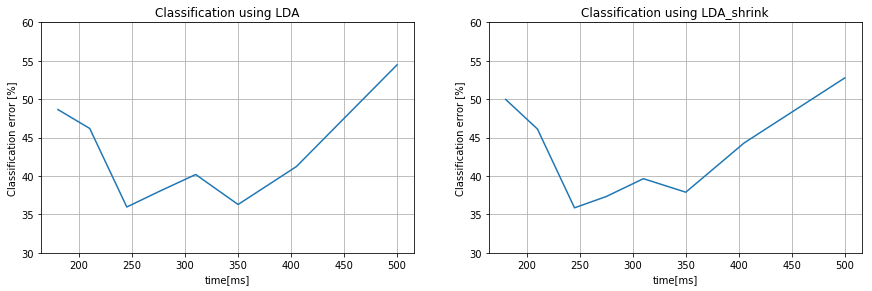

In [5]:
ival = [[160, 200], [200, 220], [230, 260], [260, 290], [300, 320], [330, 370], [380, 430], [480, 520]]

# Segment continuous data into epochs:
x = []
for i in range(len(ival)):
    x.append(bci.makeepochs(cnt, fs, mrk_pos, ival[i]))

l = np.array(x)

loss_test_lda_list =[]
loss_test_lda_shrink_list = []
conc_list = []

for i in range(l.shape[0]):
    epo_temp = l[i][0]
    X = np.mean(epo_temp,axis=0)
    conc_list.append(X)
    loss_test_lda_list.append(cfy.crossvalidation(cfy.train_LDA, X, mrk_class, folds=3, verbose=False)[0])
    loss_test_lda_shrink_list.append(cfy.crossvalidation(train_LDAshrink, X, mrk_class, folds=3, verbose=False)[0])

b = np.array([[loss_test_lda_list],[loss_test_lda_shrink_list]])
print(b)

classifiers = ['LDA', 'LDA_shrink']
for i in range(len(classifiers)):
    plt.subplot(1,2,i+1)
    plt.plot(np.mean(np.array(ival),axis=1), b[i].T)
    
    plt.title('Classification using ' + classifiers[i])
    plt.xlabel("time[ms]")
    plt.ylim(30,60)
    plt.ylabel("Classification error [%]")
    plt.grid()

plt.subplots_adjust(left = 0.1, right = 2, bottom = 0.1, top = 0.9, wspace = 0.2, hspace = 0.2)

############################## 2nd part #########################################################################

a = np.concatenate(np.array(conc_list),axis=0)

lda_test_error = cfy.crossvalidation(cfy.train_LDA, a, mrk_class, folds=3, verbose=False)[0]
lda_shrink_test_error = cfy.crossvalidation(train_LDAshrink, a, mrk_class, folds=3, verbose=False)[0]

print("\nLDA w/o shrink test error: ", lda_test_error)
print("LDA with shrink test error: ", lda_shrink_test_error)

